In [1]:
import os
import gc
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgbm
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# load merged data
len_train = 307511
merged_df = pd.read_pickle('./data/merged_df.pkl')
meta_df = pd.read_pickle('./data/meta_df.pkl')

In [3]:
#merged_df = merged_df.replace([np.inf, -np.inf], np.nan)
#merged_df.fillna(0, inplace=True)

In [4]:
target = merged_df.pop('TARGET')
target = target[:len_train]

In [5]:
# split back from merged
train_df = merged_df[:len_train]
predict_df = merged_df[len_train:]
del merged_df
gc.collect()

21

### LigntGBM + Hyperopt

In [6]:
D_train = lgbm.Dataset(data=train_df,
                       label=target,
                       free_raw_data=False)

In [7]:
X_1, X_2, y_1, y_2 = train_test_split(train_df, target, test_size=0.5, random_state=2)
sample_train = lgbm.Dataset(data=X_1,
                       label=y_1,
                       free_raw_data=False)

In [8]:
def get_lgbm_params(space):
    lgbm_params = dict()
    lgbm_params['boosting_type'] = 'dart'
    lgbm_params['application'] = 'binary'
    lgbm_params['metric'] = 'auc'
    lgbm_params['learning_rate'] = space['learning_rate']
    lgbm_params['num_leaves'] = int(space['num_leaves'])
    lgbm_params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    lgbm_params['min_sum_hessian_in_leaf'] = space['min_sum_hessian_in_leaf']
    lgbm_params['max_depth'] = -1
    lgbm_params['lambda_l1'] = space['lambda_l1'] if 'lambda_l1' in space else 0.0
    lgbm_params['lambda_l2'] = space['lambda_l2'] if 'lambda_l2' in space else 0.0
    lgbm_params['max_bin'] = int(space['max_bin']) if 'max_bin' in space else 256
    lgbm_params['feature_fraction'] = space['feature_fraction']
    lgbm_params['bagging_fraction'] = space['bagging_fraction']
    lgbm_params['bagging_freq'] = int(space['bagging_freq']) if 'bagging_freq' in space else 1
    lgbm_params['scale_pos_weight'] = int(space['scale_pos_weight'])
    lgbm_params['drop_rate'] = space['drop_rate']
    lgbm_params['min_split_gain'] = space['min_split_gain']
    lgbm_params['num_threads'] = 4  
    
    return lgbm_params

In [18]:
# Hyperopt, suggest parameters
N_HYPEROPT_PROBES = 20
HYPEROPT_ALGO = tpe.suggest  #  tpe.suggest OR hyperopt.rand.suggest

obj_call_count = 0
cur_best_auc = 0
log_writer = open('lgb-hyperopt-log.txt', 'w')


def objective(space):
    global obj_call_count, cur_best_auc

    obj_call_count += 1

    print('\nXGB objective call #{} cur_best_auc={:7.5f}'.format(obj_call_count, cur_best_auc) )

    lgbm_params = get_lgbm_params(space)

    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in space.items()])
    print('Params: {}'.format(params_str))
    
    model = lgbm.cv(train_set=sample_train,
                    params=lgbm_params,
                    nfold=4,
                    num_boost_round=10000,
                    early_stopping_rounds=150,
                    verbose_eval=50
                   )

    nb_rounds = np.argmax(model['auc-mean'])
    val_auc = np.max(model['auc-mean'])
    print('nb_rounds={} val_auc={}'.format(nb_rounds, val_auc))

    log_writer.write('auc={:<7.5f} Params:{} nb_rounds={}\n'.format(val_auc, params_str, nb_rounds))
    log_writer.flush()

    if val_auc > cur_best_auc:
        cur_best_auc = val_auc
        print('NEW BEST AUC={}'.format(cur_best_auc))

    return{'loss':1-val_auc, 'status': STATUS_OK}


# --------------------------------------------------------------------------------

space = {
    
    'learning_rate': hp.quniform('learning_rate', 0.02, 0.08, 0.01),
    'num_leaves': hp.quniform ('num_leaves', 16, 32, 1),
    'min_data_in_leaf': hp.quniform ('min_data_in_leaf', 32, 64, 8),
    'min_sum_hessian_in_leaf': hp.quniform('min_sum_hessian_in_leaf', 0.5, 1.5, 0.1),
    'lambda_l1': hp.quniform('lambda_l1', 0, 6, 1),
    'lambda_l2': hp.quniform('lambda_l2', 0, 6, 1),
    'max_bin': hp.quniform ('max_bin', 196, 320, 32),
    'feature_fraction': hp.quniform('feature_fraction', 0.3, 0.9, 0.1),
    'bagging_fraction':  hp.quniform('bagging_fraction', 0.6, 1.0, 0.1),
    'bagging_freq':  hp.quniform ('bagging_freq', 1, 3, 1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 2, 0.25),
    'drop_rate': hp.quniform('drop_rate', 0, 0.1, 0.025),
    'min_split_gain': hp.quniform('min_split_gain', 0, 0.1, 0.025)
}

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')


XGB objective call #1 cur_best_auc=0.00000
Params: bagging_fraction=0.9 bagging_freq=2.0 drop_rate=0.05 feature_fraction=0.5 lambda_l1=1.0 lambda_l2=0.0 learning_rate=0.02 max_bin=224.0 min_data_in_leaf=40.0 min_split_gain=0.05 min_sum_hessian_in_leaf=1.1 num_leaves=23.0 scale_pos_weight=1.5
[50]	cv_agg's auc: 0.744913 + 0.00340982
[100]	cv_agg's auc: 0.747478 + 0.00306679
[150]	cv_agg's auc: 0.748903 + 0.00298813
[200]	cv_agg's auc: 0.750089 + 0.00291376
[250]	cv_agg's auc: 0.752259 + 0.00289432
[300]	cv_agg's auc: 0.754285 + 0.00314681
[350]	cv_agg's auc: 0.755694 + 0.00320267
[400]	cv_agg's auc: 0.759335 + 0.0033505
[450]	cv_agg's auc: 0.76091 + 0.00350797
[500]	cv_agg's auc: 0.762989 + 0.00367091
[550]	cv_agg's auc: 0.764228 + 0.00365337
[600]	cv_agg's auc: 0.766115 + 0.00370157
[650]	cv_agg's auc: 0.767626 + 0.00371628
[700]	cv_agg's auc: 0.768325 + 0.00373
[750]	cv_agg's auc: 0.768942 + 0.00387034
[800]	cv_agg's auc: 0.77001 + 0.00392955
[850]	cv_agg's auc: 0.770963 + 0.0039748


[900]	cv_agg's auc: 0.785554 + 0.0035136
[950]	cv_agg's auc: 0.785827 + 0.00339856
[1000]	cv_agg's auc: 0.785658 + 0.00319746
[1050]	cv_agg's auc: 0.785963 + 0.0032014
[1100]	cv_agg's auc: 0.786026 + 0.00331486
[1150]	cv_agg's auc: 0.786243 + 0.00332363
[1200]	cv_agg's auc: 0.786479 + 0.00328648
[1250]	cv_agg's auc: 0.786367 + 0.00318797
[1300]	cv_agg's auc: 0.786569 + 0.00331053
[1350]	cv_agg's auc: 0.786797 + 0.00359143
[1400]	cv_agg's auc: 0.786809 + 0.00356058
[1450]	cv_agg's auc: 0.786698 + 0.00360799
[1500]	cv_agg's auc: 0.786821 + 0.00385514
[1550]	cv_agg's auc: 0.78689 + 0.00380793
[1600]	cv_agg's auc: 0.786887 + 0.0037229
[1650]	cv_agg's auc: 0.786965 + 0.00373661
[1700]	cv_agg's auc: 0.786954 + 0.00368899
nb_rounds=1561 val_auc=0.7870010952962858

XGB objective call #5 cur_best_auc=0.78750
Params: bagging_fraction=0.6000000000000001 bagging_freq=2.0 drop_rate=0.0 feature_fraction=0.4 lambda_l1=4.0 lambda_l2=6.0 learning_rate=0.07 max_bin=224.0 min_data_in_leaf=56.0 min_split_

nb_rounds=851 val_auc=0.785877919570886

XGB objective call #10 cur_best_auc=0.78750
Params: bagging_fraction=0.8 bagging_freq=3.0 drop_rate=0.1 feature_fraction=0.6000000000000001 lambda_l1=5.0 lambda_l2=1.0 learning_rate=0.07 max_bin=288.0 min_data_in_leaf=40.0 min_split_gain=0.05 min_sum_hessian_in_leaf=1.4000000000000001 num_leaves=31.0 scale_pos_weight=1.0
[50]	cv_agg's auc: 0.751257 + 0.00193537
[100]	cv_agg's auc: 0.760944 + 0.00360288
[150]	cv_agg's auc: 0.765138 + 0.00411388
[200]	cv_agg's auc: 0.769451 + 0.00411699
[250]	cv_agg's auc: 0.773516 + 0.00412994
[300]	cv_agg's auc: 0.777576 + 0.0041015
[350]	cv_agg's auc: 0.779613 + 0.00420696
[400]	cv_agg's auc: 0.781757 + 0.00405931
[450]	cv_agg's auc: 0.783439 + 0.00423463
[500]	cv_agg's auc: 0.78426 + 0.00434259
[550]	cv_agg's auc: 0.784526 + 0.00411595
[600]	cv_agg's auc: 0.784771 + 0.00406989
[650]	cv_agg's auc: 0.785264 + 0.00353974
[700]	cv_agg's auc: 0.785412 + 0.00345703
[750]	cv_agg's auc: 0.785868 + 0.00350643
[800]	cv_

KeyboardInterrupt: 

In [ ]:
# Train with best parameters
cv_results = lgbm.cv(train_set=D_train,
                     params=get_lgbm_params(best),
                     nfold=4,
                     num_boost_round=3000,
                     early_stopping_rounds=100,
                     verbose_eval=50
                    )

nb_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(nb_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=nb_rounds)

In [ ]:
# Predict for kaggle
y_pred = clf.predict(predict_df)
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
out_df.to_csv('submission.csv', index=False)

### Temp

In [21]:
lgbm_params = {
    #'boosting': 'dart',
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': 0.02,
    'num_leaves': 32,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 40,
    'lambda_l1': 3,
    'lambda_l2': 5,
    'max_bin': 256,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.85,
    'bagging_freq': 2,
    'scale_pos_weight': 1.5,
    #'drop_rate': 0.03,
    'min_split_gain': 0.02,
    'max_depth': -1,
    'num_threads': 4
}

In [22]:
cv_results = lgbm.cv(train_set=D_train,
                     params=lgbm_params,
                     nfold=4,
                     num_boost_round=10000,
                     early_stopping_rounds=250,
                     verbose_eval=50
                    )

nb_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(nb_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

[50]	cv_agg's auc: 0.751502 + 0.00135704
[100]	cv_agg's auc: 0.760797 + 0.000855411
[150]	cv_agg's auc: 0.765621 + 0.000655976
[200]	cv_agg's auc: 0.771111 + 0.000864911
[250]	cv_agg's auc: 0.774732 + 0.00102496
[300]	cv_agg's auc: 0.778282 + 0.00108425
[350]	cv_agg's auc: 0.780239 + 0.00095127
[400]	cv_agg's auc: 0.782864 + 0.00107584
[450]	cv_agg's auc: 0.784815 + 0.0010037
[500]	cv_agg's auc: 0.78556 + 0.000952854
[550]	cv_agg's auc: 0.78632 + 0.00108348
[600]	cv_agg's auc: 0.787461 + 0.000951701
[650]	cv_agg's auc: 0.788307 + 0.00109675
[700]	cv_agg's auc: 0.78868 + 0.00110097
[750]	cv_agg's auc: 0.78904 + 0.0011101
[800]	cv_agg's auc: 0.789437 + 0.00121732
[850]	cv_agg's auc: 0.7896 + 0.00125209
[900]	cv_agg's auc: 0.790206 + 0.00132758
[950]	cv_agg's auc: 0.790077 + 0.00135411
[1000]	cv_agg's auc: 0.790269 + 0.00139351
[1050]	cv_agg's auc: 0.790437 + 0.00138833
[1100]	cv_agg's auc: 0.7908 + 0.00134309
[1150]	cv_agg's auc: 0.790907 + 0.00125006
[1200]	cv_agg's auc: 0.791411 + 0.00

In [6]:
clf = lgbm.train(train_set=D_train,
                 params=lgbm_params,
                 num_boost_round=2400)

In [7]:
y_pred = clf.predict(predict_df)
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
out_df.to_csv('submission.csv', index=False)

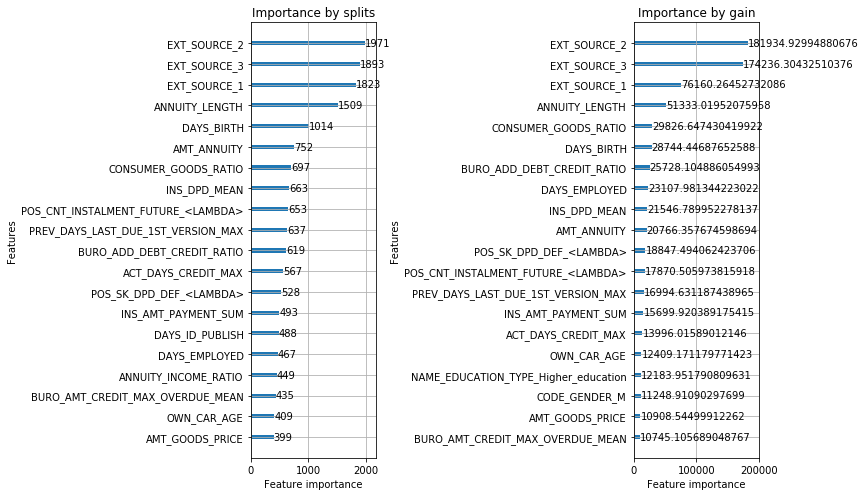

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[11, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
#plt.savefig('feature_importance.png')

### Temp

In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04, 
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        silent=-1,
        verbose=-1)

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=2)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(predict_df.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, target)):
    train_x, train_y = train_df.iloc[train_idx], target.iloc[train_idx]
    valid_x, valid_y = train_df.iloc[valid_idx], target.iloc[valid_idx]
    
    clf = LGBMClassifier(
        #boosting_type='dart'
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=32,
        feature_fraction=0.75,
        bagging_fraction=0.85,
        bagging_freq=2,
        max_depth=12,
        reg_alpha=3,
        reg_lambda=5,
        min_split_gain=0.02,
        min_data_in_leaf=20,
        min_sum_hessian_in_leaf=40,
        #drop_rate=0.03,
        silent=-1,
        verbose=-1)

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric='auc', verbose=50, early_stopping_rounds=200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(predict_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_df.columns.values
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    #del clf, train_x, train_y, valid_x, valid_y
    #gc.collect()

print('Full AUC score %.6f' % roc_auc_score(target, oof_preds))

# Write submission file and plot feature importance
y_pred = sub_preds
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
out_df.to_csv('submission.csv', index=False)

Training until validation scores don't improve for 200 rounds.
[50]	training's auc: 0.751468	valid_1's auc: 0.736207
[100]	training's auc: 0.759476	valid_1's auc: 0.742255
[150]	training's auc: 0.772246	valid_1's auc: 0.751987
[200]	training's auc: 0.783383	valid_1's auc: 0.760341
[250]	training's auc: 0.7933	valid_1's auc: 0.768605
[300]	training's auc: 0.801309	valid_1's auc: 0.774254
[350]	training's auc: 0.807667	valid_1's auc: 0.778167
[400]	training's auc: 0.813215	valid_1's auc: 0.781031
[450]	training's auc: 0.818232	valid_1's auc: 0.783117
[500]	training's auc: 0.822828	valid_1's auc: 0.784783
[550]	training's auc: 0.827069	valid_1's auc: 0.786087
[600]	training's auc: 0.831234	valid_1's auc: 0.787229
[650]	training's auc: 0.834907	valid_1's auc: 0.788052
[700]	training's auc: 0.838527	valid_1's auc: 0.788694
[750]	training's auc: 0.841999	valid_1's auc: 0.789244
[800]	training's auc: 0.845282	valid_1's auc: 0.789696
[850]	training's auc: 0.848539	valid_1's auc: 0.790001
[900]

[550]	training's auc: 0.826483	valid_1's auc: 0.789949
[600]	training's auc: 0.830454	valid_1's auc: 0.791039
[650]	training's auc: 0.834231	valid_1's auc: 0.791742
[700]	training's auc: 0.837872	valid_1's auc: 0.792413
[750]	training's auc: 0.841281	valid_1's auc: 0.792878
[800]	training's auc: 0.844599	valid_1's auc: 0.793289
[850]	training's auc: 0.847517	valid_1's auc: 0.793519
[900]	training's auc: 0.850547	valid_1's auc: 0.793941
[950]	training's auc: 0.853557	valid_1's auc: 0.7942
[1000]	training's auc: 0.856435	valid_1's auc: 0.794452
[1050]	training's auc: 0.859152	valid_1's auc: 0.794593
[1100]	training's auc: 0.86174	valid_1's auc: 0.794726
[1150]	training's auc: 0.864498	valid_1's auc: 0.794904
[1200]	training's auc: 0.867075	valid_1's auc: 0.795188
[1250]	training's auc: 0.869681	valid_1's auc: 0.795224
[1300]	training's auc: 0.872201	valid_1's auc: 0.795336
[1350]	training's auc: 0.874579	valid_1's auc: 0.795325
[1400]	training's auc: 0.876914	valid_1's auc: 0.795525
[145